In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K

C:\Users\NightMare\anaconda3\envs\envGPU\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\NightMare\anaconda3\envs\envGPU\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\NightMare\anaconda3\envs\envGPU\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
train_data = pd.read_csv('C:/Users/NightMare/Desktop/neurofeed_back/Preprocessdata/train_osn/test_obj_23.csv')
valid_data = pd.read_csv('C:/Users/NightMare/Desktop/neurofeed_back/Preprocessdata/train_df_obj0.csv')
test_data  = pd.read_csv('C:/Users/NightMare/Desktop/neurofeed_back/Preprocessdata/valid_df_obj0.csv')

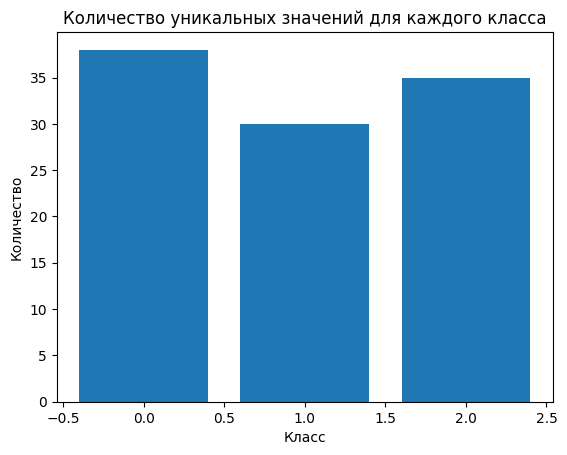

[0.90350877 0.98095238 1.14444444]
{0: 0.9035087719298246, 2: 0.9809523809523809, 1: 1.1444444444444444}


In [3]:
# Подсчет количества элементов класса_1 и класса_2 в столбце_1
class_counts = train_data['label'].value_counts()

# Построение гистограммы
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.title('Количество уникальных значений для каждого класса')
plt.show()

from sklearn.utils.class_weight import compute_class_weight

# Получение уникальных меток классов
class_labels = train_data['label'].unique()

# Рассчитываем веса классов
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=train_data['label'])

print(class_weights)

# Создаем словарь с весами классов
class_weight_dict = dict(zip(class_labels, class_weights))

print(class_weight_dict)

In [4]:
tr_text = train_data['text']
tr_label = train_data['label']

val_text = valid_data['text']
val_label = valid_data['label']

ts_text = test_data['text']
ts_label = test_data['label']

In [5]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(tr_text) 
                            
sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=512) 
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=512)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=512)
ts_y = to_categorical(ts_label)

In [6]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2):
    epsilon = 1e-9
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    focal_loss = -alpha * (1 - pt) ** gamma * tf.math.log(pt)
    return tf.reduce_mean(focal_loss)

def f1_score(y_true, y_pred):
    # Округляем предсказанные значения до бинарных (0 или 1)
    y_pred = K.round(y_pred)

    # Ищем True Positives, False Positives и False Negatives
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    # Вычисляем precision и recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Вычисляем F1 score
    f1_score = 2 * precision * recall / (precision + recall + K.epsilon())
    
    # Усредняем F1 score по классам и возвращаем результат
    return K.mean(f1_score)

In [7]:
max_words = 20000
max_len = 512
embedding_dim = 32

In [8]:
# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(512, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(512, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())

concatenated = Concatenate()([branch1.output, branch2.output])

hid_layer = Dense(512, activation='relu')(concatenated)
dropout = Dropout(0.3)(hid_layer)
output_layer = Dense(3, activation='softmax')(dropout)

model = Model(inputs=[branch1.input, branch2.input], outputs=output_layer)

In [9]:
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Определение обратного вызова для уменьшения скорости обучения
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Использование:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 embedding_1_input (InputLayer)  [(None, 512)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 512, 32)      640000      ['embedding_input[0][0]']        
                                                                                                  
 embedding_1 (Embedding)        (None, 512, 32)      640000      ['embedding_1_input[0][0]']      
                                                                                              

In [10]:
batch_size = 256
epochs = 15
# Обучение модели с использованием обратного вызова
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y),
                    callbacks=[reduce_lr])

Epoch 1/15
1/1 [==============================] - 4s 4s/step - loss: 1.4045 - accuracy: 0.2816 - f1_score: 0.2144 - val_loss: 1.1033 - val_accuracy: 0.3327 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/15
1/1 [==============================] - 0s 145ms/step - loss: 4.3992 - accuracy: 0.3010 - f1_score: 0.1686 - val_loss: 1.1036 - val_accuracy: 0.3327 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/15
1/1 [==============================] - 0s 146ms/step - loss: 4.6836 - accuracy: 0.3689 - f1_score: 0.1797 - val_loss: 1.1008 - val_accuracy: 0.3346 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/15
1/1 [==============================] - 0s 148ms/step - loss: 2.4619 - accuracy: 0.4078 - f1_score: 0.2866 - val_loss: 1.0995 - val_accuracy: 0.3346 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 5/15
1/1 [==============================] - 0s 147ms/step - loss: 2.4487 - accuracy: 0.3689 - f1_score: 0.2062 - val_loss: 1.0981 - val_accuracy: 0.3364 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 6/

In [11]:
(loss, accuracy, f1) = model.evaluate([tr_x, tr_x], tr_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, F1: {round(f1, 2)}')

4/4 [==============================] - 0s 8ms/step - loss: 1.0570 - accuracy: 0.9612 - f1_score: 0.0000e+00
Loss: 1.06, Accuracy: 0.96, F1: 0.0


In [12]:
(loss, accuracy, f1) = model.evaluate([ts_x, ts_x], ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, F1: {round(f1, 2)}')

6/6 [==============================] - 0s 8ms/step - loss: 1.0977 - accuracy: 0.3333 - f1_score: 0.0000e+00
Loss: 1.1, Accuracy: 0.33, F1: 0.0


In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score', 'lr'])

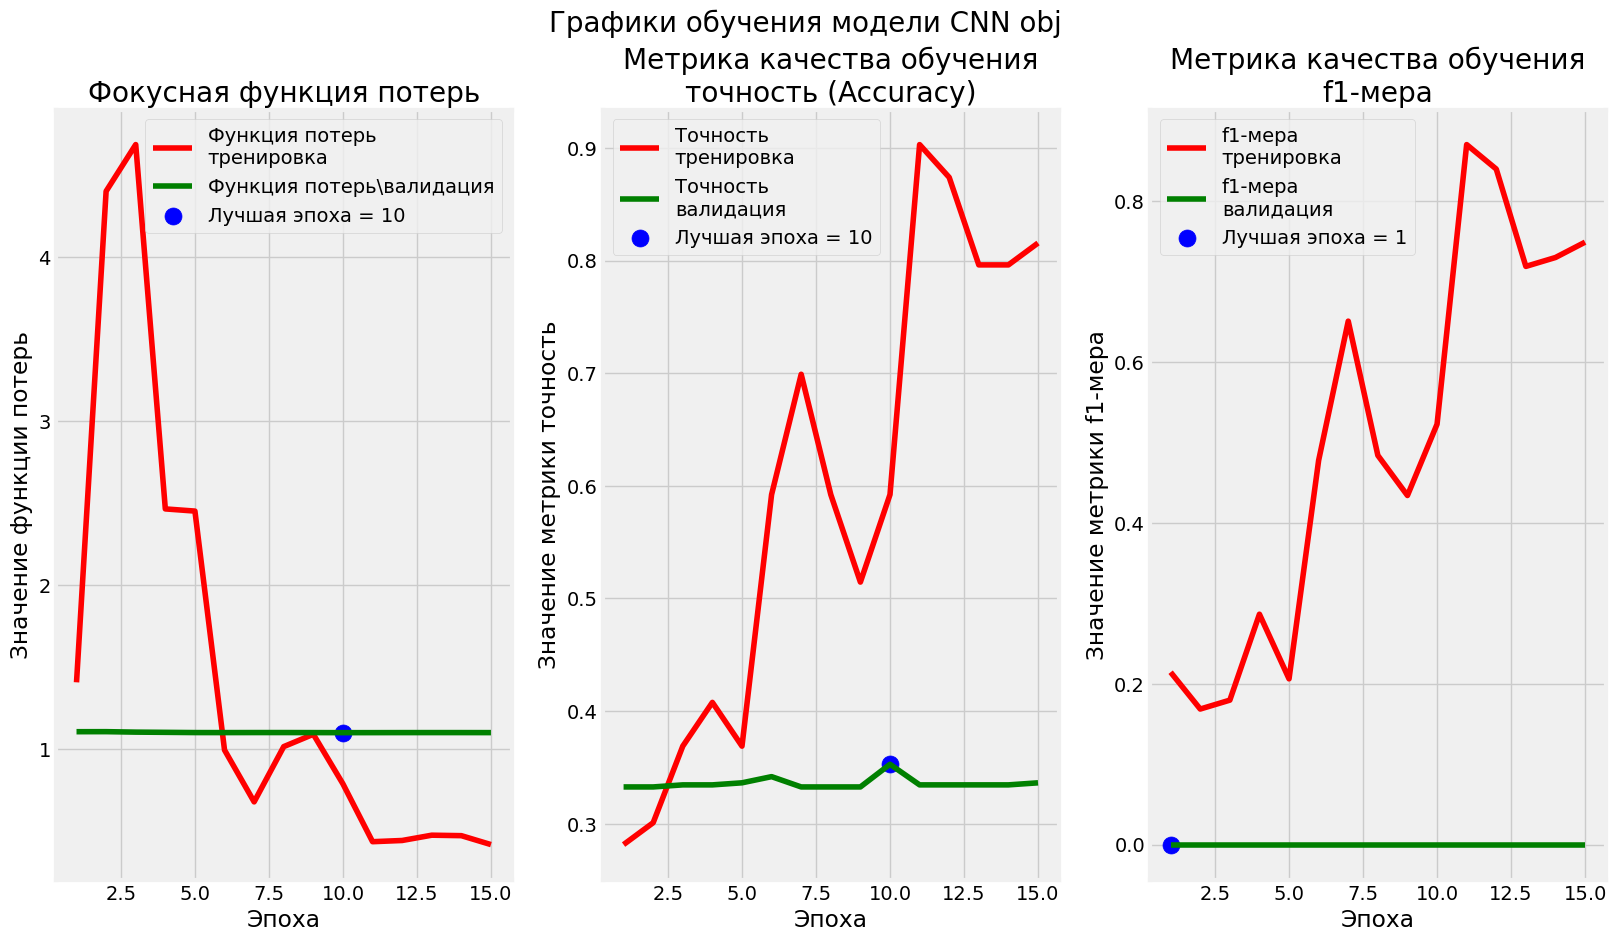

In [14]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_f1 = history.history['f1_score']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_f1 = history.history['val_f1_score']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_f1 = np.argmax(val_f1)
f1_highest = val_f1[index_f1]


Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Лучшая эпоха = {str(index_loss + 1)}'
acc_label = f'Лучшая эпоха = {str(index_acc + 1)}'
f1_label = f'Лучшая эпоха = {str(index_f1 + 1)}'


fig = plt.figure(figsize=(20, 10))
plt.style.use('fivethirtyeight')


plt.subplot(1, 3, 1)
plt.plot(Epochs, tr_loss, 'r', label='Функция потерь\nтренировка')
plt.plot(Epochs, val_loss, 'g', label='Функция потерь\валидация')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Фокусная функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(Epochs, tr_acc, 'r', label='Точность\nтренировка')
plt.plot(Epochs, val_acc, 'g', label='Точность\nвалидация')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Метрика качества обучения\nточность (Accuracy)')
plt.xlabel('Эпоха')
plt.ylabel('Значение метрики точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(Epochs, tr_f1, 'r', label='f1-мера\nтренировка')
plt.plot(Epochs, val_f1, 'g', label='f1-мера\nвалидация')
plt.scatter(index_f1 + 1, f1_highest, s=150, c='blue', label=f1_label)
plt.title('Метрика качества обучения\nf1-мера')
plt.xlabel('Эпоха')
plt.ylabel('Значение метрики f1-мера')
plt.legend()
plt.grid(True)

plt.suptitle('Графики обучения модели CNN obj', fontsize=20)
plt.show()
fig.savefig("plot_train_obj", dpi=1000)

In [15]:
y_true=[]
for i in range(len(ts_y)):
    
    x = np.argmax(ts_y[i]) 
    y_true.append(x)

In [16]:
preds = model.predict([ts_x, ts_x])
y_pred = np.argmax(preds, axis=1)
y_pred

6/6 [==============================] - 0s 5ms/step


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2], dtype=int64)

<Axes: >

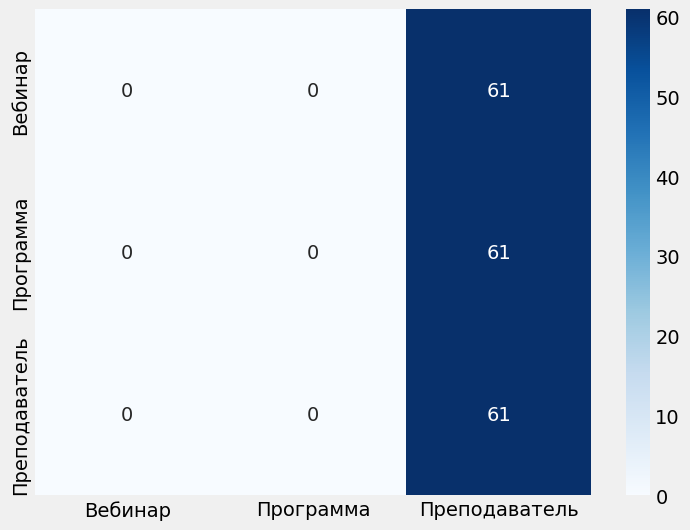

In [17]:
fig = plt.figure(figsize=(8,6))
emotions = {0: 'Вебинар', 1: 'Программа', 2: 'Преподаватель'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
# fig.savefig("conf_matrix", dpi=1000)

C:\Users\NightMare\anaconda3\envs\envGPU\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\NightMare\anaconda3\envs\envGPU\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\NightMare\anaconda3\envs\envGPU\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


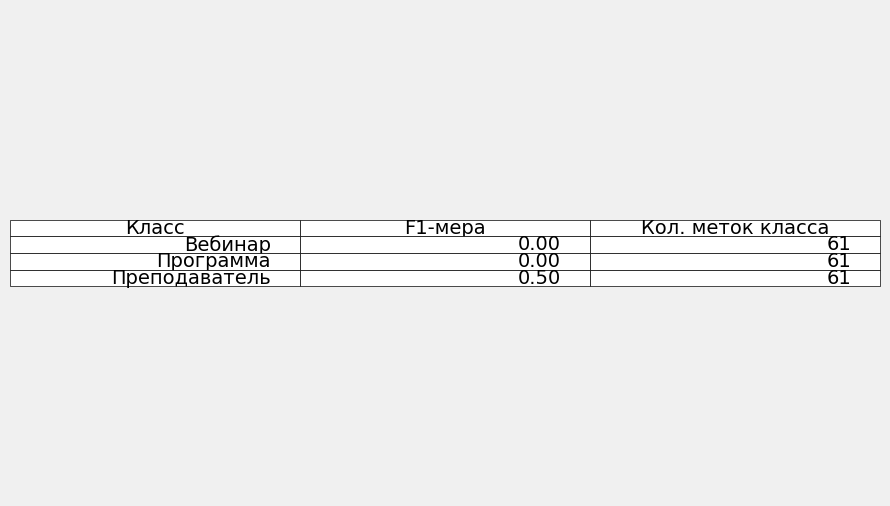

In [18]:
clr = classification_report(y_true, y_pred)

# Преобразование текста отчета о классификации в массив NumPy
report_data = []
report_lines = clr.split('\n')
for line in report_lines[2:-5]:  # Игнорируем первые две строки заголовка и последние пять строк с общими показателями
    row_data = line.split()
    # Замена значений классов 0 и 1 на "negative" и "positive"
    if row_data[0] == '0':
        row_data[0] = 'Вебинар'
    elif row_data[0] == '1':
        row_data[0] = 'Программа'
    elif row_data[0] == '2':
        row_data[0] = 'Преподаватель'
    row_data = [row_data[0], row_data[3], row_data[4]]  # Пропускаем столбцы Precision и Recall
    report_data.append(row_data)

# Создание таблицы matplotlib
fig, ax = plt.subplots(figsize=(10, 6))  # Установка размеров рисунка
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=report_data, loc='center', colLabels=['Класс', 'F1-мера', 'Кол. меток класса'])

# Сохранение рисунка
# plt.savefig('classification_report.png', dpi=1000)  # Сохранить в виде изображения
plt.show()

In [19]:
import pickle
with open('tokenizer_obj.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('nlp_obj.h5')

In [20]:
def load_model_with_focal_loss(model_path):
    custom_objects = {'focal_loss': focal_loss, 'f1_score': f1_score}  # Добавляем пользовательскую функцию потерь в custom_objects
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    return model

In [21]:
import numpy as np

# Функция predict остается неизменной, но при вызове используется numpy.argmax для определения предсказанного класса

def predict(text, model_path, token_path):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import pickle
    from tensorflow.keras.models import load_model
    
    model = load_model_with_focal_loss(model_path)
    
    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    sequences = tokenizer.texts_to_sequences(text)
    x_new = pad_sequences(sequences, maxlen=512)
    predictions = model.predict([x_new, x_new])
    
    # Использование numpy.argmax для определения предсказанного класса
    predicted_labels = np.argmax(predictions, axis=1)
    
    return predicted_labels

# Загрузка данных test_data и их предсказание
texts = list(test_data['text'])
labels = list(test_data['label'])

predicted_labels = predict(texts, 'nlp_obj.h5', 'tokenizer_obj.pkl')

# Вызов функции precision_recall_fscore_support с обновленными labels и predicted_labels
from sklearn.metrics import precision_recall_fscore_support

_, _, f1score, _ = precision_recall_fscore_support(labels, predicted_labels, average='micro')

print(f'f1score: {f1score}')

df = pd.DataFrame()
df = test_data
df['predict'] = predicted_labels
df

6/6 [==============================] - 0s 5ms/step
f1score: 0.3333333333333333


,text,label,predict
0,преподаватель на вебинаре обладает высоким уро...,2,2
1,благодарим за интерес к нашему вебинару мы рад...,0,2
2,программа вебинара была очень информативной и ...,1,2
3,преподаватель вебинара был профессионалом свое...,2,2
4,программа вебинара была очень информативной и ...,1,2
...,...,...,...
178,отличный вебинар спикер держал внимание аудито...,0,2
179,прошел увлекательный и информативный вебинар с...,0,2
180,отличный вебинар спикер был очень компетентным...,0,2
181,преподаватель на вебинаре произвел на меня оче...,2,2


In [22]:
def predict1(text, model_path, token_path):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import matplotlib.pyplot as plt
    import pickle
    from tensorflow.keras.models import load_model
    
    model = load_model_with_focal_loss(model_path)
    
    
    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    sequences = tokenizer.texts_to_sequences([text])
    x_new = pad_sequences(sequences, maxlen=512)
    predictions = model.predict([x_new, x_new])
    
    emotions = {0: 'vebinar', 1: 'program', 2: 'teacher'}
    
    label = list(emotions.values())
    probs = list(predictions[0])
    labels = label
    plt.subplot(1, 1, 1)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

In [23]:
import numpy as np

test_data = pd.read_csv('C:/Users/NightMare/Desktop/neurofeed_back/Preprocessdata/train_osn/test_df_obj0.csv')

# Функция predict остается неизменной, но при вызове используется numpy.argmax для определения предсказанного класса

def predict(text, model_path, token_path):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import pickle
    from tensorflow.keras.models import load_model
    
    model = load_model_with_focal_loss(model_path)
    
    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    sequences = tokenizer.texts_to_sequences(text)
    x_new = pad_sequences(sequences, maxlen=512)
    predictions = model.predict([x_new, x_new])
    
    # Использование numpy.argmax для определения предсказанного класса
    predicted_labels = np.argmax(predictions, axis=1)
    
    return predicted_labels

# Загрузка данных test_data и их предсказание
texts = list(test_data['text'])
labels = list(test_data['label'])

predicted_labels = predict(texts, 'nlp_obj.h5', 'tokenizer_obj.pkl')

y_true=[]
for i in range(len(labels)):

    y_true.append(labels[i])
    
y_pred = predicted_labels

# Вызов функции precision_recall_fscore_support с обновленными labels и predicted_labels
from sklearn.metrics import precision_recall_fscore_support

_, _, f1score, _ = precision_recall_fscore_support(labels, predicted_labels, average='micro')

print(f'f1score: {f1score}')

df = pd.DataFrame()
df = test_data
df['predict'] = predicted_labels
df

1/1 [==============================] - 0s 100ms/step
f1score: 0.9523809523809523


,text,label,predict
0,продвинутые техники программирования вебинар п...,1,1
1,основы программирования дискуссия о том как пи...,0,0
2,основы программирования преподователь супер не...,2,2
3,управление персоналом все понравилось календар...,1,1
4,основы программирования интерактивный подход п...,0,0
5,продвинутые техники программирования подробный...,1,1
6,новейшие тенденции в it презентация о развитии...,2,2
7,основы программирования подробный разбор проце...,0,0
8,основы программирования майкнафт вспомнили про...,1,2
9,продвинутые техники программирования сессия по...,1,1


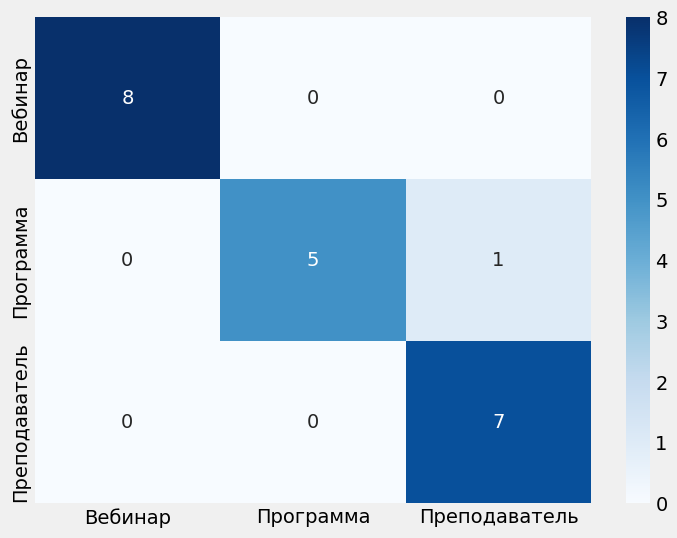

In [24]:
fig = plt.figure(figsize=(8,6))
emotions = {0: 'Вебинар', 1: 'Программа', 2: 'Преподаватель'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
fig.savefig("conf_matrix_obj.png", dpi=1000)

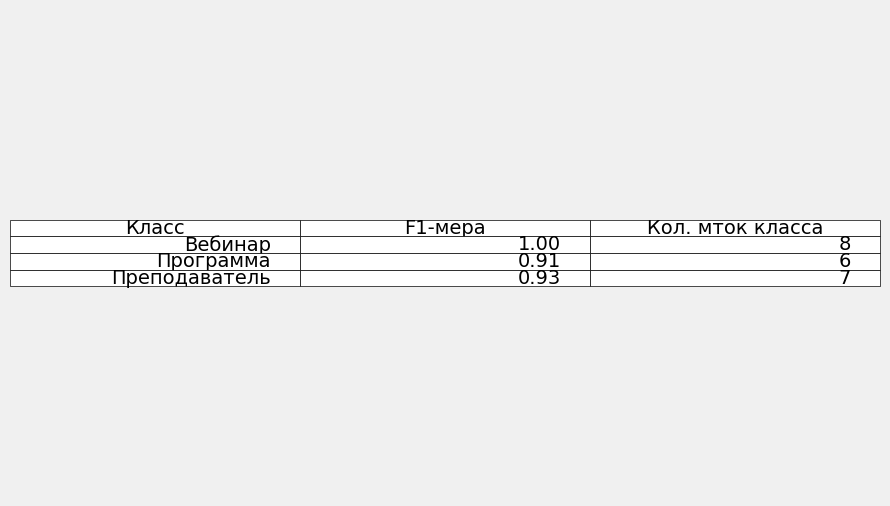

In [25]:
clr = classification_report(y_true, y_pred)

# Преобразование текста отчета о классификации в массив NumPy
report_data = []
report_lines = clr.split('\n')
for line in report_lines[2:-5]:  # Игнорируем первые две строки заголовка и последние пять строк с общими показателями
    row_data = line.split()
    # Замена значений классов 0 и 1 на "negative" и "positive"
    if row_data[0] == '0':
        row_data[0] = 'Вебинар'
    elif row_data[0] == '1':
        row_data[0] = 'Программа'
    elif row_data[0] == '2':
        row_data[0] = 'Преподаватель'
    row_data = [row_data[0], row_data[3], row_data[4]]  # Пропускаем столбцы Precision и Recall
    report_data.append(row_data)

# Создание таблицы matplotlib
fig, ax = plt.subplots(figsize=(10, 6))  # Установка размеров рисунка
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=report_data, loc='center', colLabels=['Класс', 'F1-мера', 'Кол. мток класса'])

# Сохранение рисунка
plt.savefig('classification_report_obj.png', dpi=1000)  # Сохранить в виде изображения
plt.show()